Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

In [24]:
# Decision Tree trained on on raw data, and tested on raw data. 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm


In [25]:
from MakeTask4Dataset import X_train, X_test, y_train, y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (50, 500, 3)
X_test shape: (22, 500, 3)
y_train shape: (50,)
y_test shape: (22,)
X_train_flat shape: (50, 1500)
X_test_flat shape: (22, 1500)


In [26]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [27]:

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.50      0.50      0.50         4
  WALKING_UPSTAIRS       1.00      0.50      0.67         4
WALKING_DOWNSTAIRS       0.50      0.25      0.33         4
           SITTING       0.60      0.75      0.67         4
          STANDING       0.50      1.00      0.67         3
            LAYING       1.00      1.00      1.00         3

          accuracy                           0.64        22
         macro avg       0.68      0.67      0.64        22
      weighted avg       0.68      0.64      0.62        22

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.5000, Recall = 0.5000, Accuracy = 0.8182
Class WALKING_UPSTAIRS: Precision = 1.0000, Recall = 0.5000, Accuracy = 0.9091
Class WALKING_DOWNSTAIRS: Precision = 0.5000, Recall = 0.2500, Accuracy = 0.8182
Class SITTING: Precision = 0.6000, Recall = 0.7500, Accuracy = 0.8636
Class STANDING: Precision

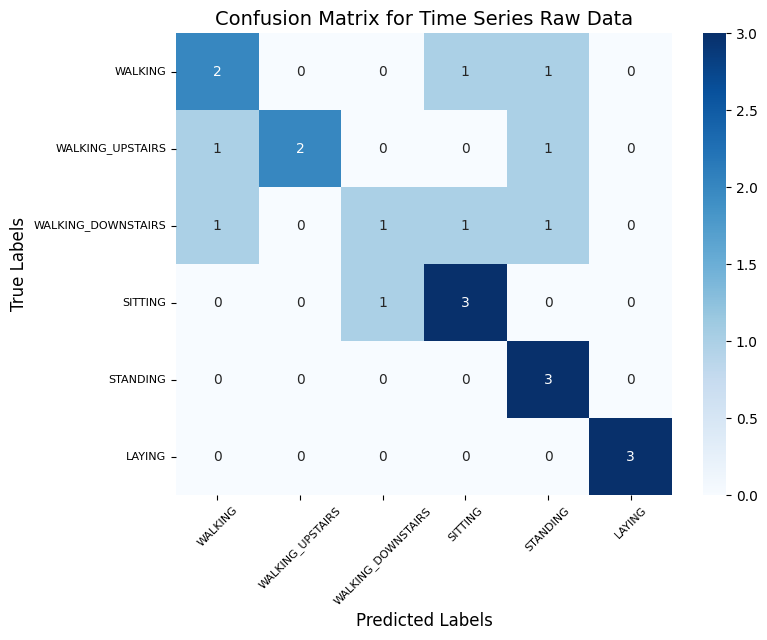

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


In [29]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir = 'Datasets/task4_datacollection/TSFEL_dataset'

X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


X_train shape: (60, 1, 1173)
y_train shape: (60,)
X_test shape: (12, 1, 1173)
y_test shape: (12,)
X_train_flat shape: (60, 1173)
X_test_flat shape: (12, 1173)


In [30]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         2
  WALKING_UPSTAIRS       1.00      1.00      1.00         2
WALKING_DOWNSTAIRS       1.00      1.00      1.00         2
           SITTING       1.00      1.00      1.00         2
          STANDING       1.00      0.50      0.67         2
            LAYING       0.67      1.00      0.80         2

          accuracy                           0.92        12
         macro avg       0.94      0.92      0.91        12
      weighted avg       0.94      0.92      0.91        12

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 1.0000
Class WALKING_UPSTAIRS: Precision = 1.0000, Recall = 1.0000, Accuracy = 1.0000
Class WALKING_DOWNSTAIRS: Precision = 1.0000, Recall = 1.0000, Accuracy = 1.0000
Class SITTING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.9167
Class STANDING: Precision

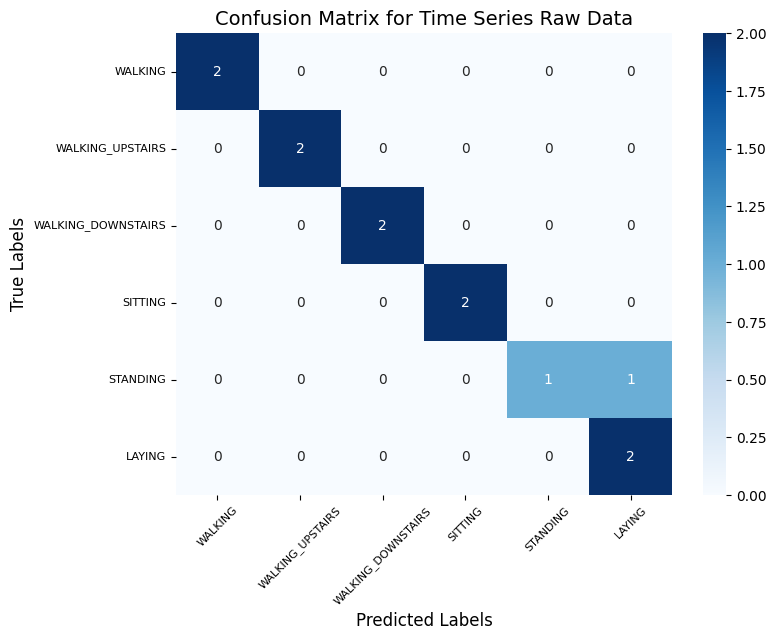

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


# Testing using Raw HAR data 

In [33]:
from MakeDataset import X_train, y_train
from MakeTask4Dataset import X as X_test, y as y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (72, 500, 3)
y_train shape: (126,)
y_test shape: (72,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (72, 1500)


In [34]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [35]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.29      0.17      0.21        12
  WALKING_UPSTAIRS       0.00      0.00      0.00        12
WALKING_DOWNSTAIRS       0.33      0.58      0.42        12
           SITTING       0.07      0.17      0.10        12
          STANDING       1.00      0.17      0.29        12
            LAYING       1.00      1.00      1.00        12

          accuracy                           0.35        72
         macro avg       0.45      0.35      0.34        72
      weighted avg       0.45      0.35      0.34        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2857, Recall = 0.1667, Accuracy = 0.7917
Class WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
Class WALKING_DOWNSTAIRS: Precision = 0.3333, Recall = 0.5833, Accuracy = 0.7361
Class SITTING: Precision = 0.0667, Recall = 0.1667, Accuracy = 0.4722
Class STANDING: Precision

c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

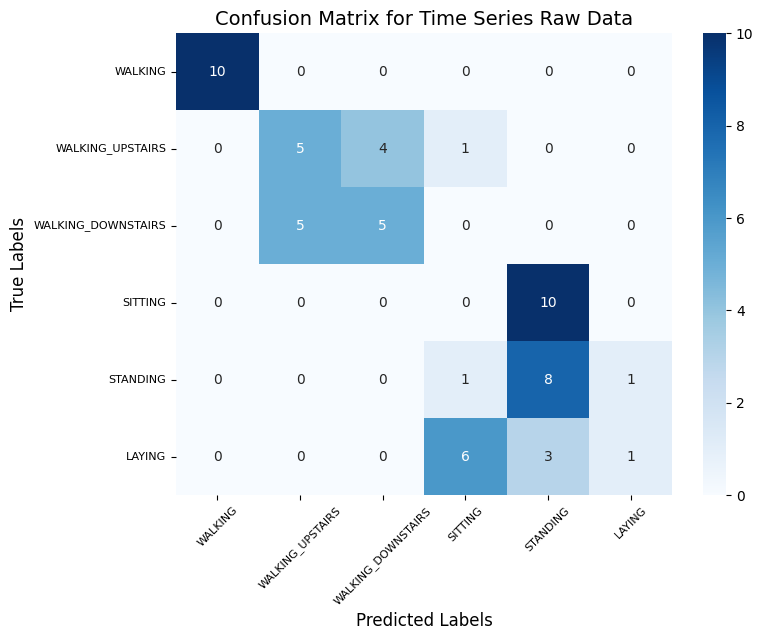

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


# Testing using TSFEL Features

In [37]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir1 = 'Datasets/TSFEL_3axes_allfeatures'  
base_dir2 = 'Datasets/task4_datacollection/TSFEL_dataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


X_train shape: (126, 1, 1173)
y_train shape: (126,)
X_test shape: (60, 1, 1173)
y_test shape: (60,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (60, 1173)


In [38]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [39]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00        10
  WALKING_UPSTAIRS       0.50      0.50      0.50        10
WALKING_DOWNSTAIRS       0.56      0.50      0.53        10
           SITTING       0.00      0.00      0.00        10
          STANDING       0.38      0.80      0.52        10
            LAYING       0.50      0.10      0.17        10

          accuracy                           0.48        60
         macro avg       0.49      0.48      0.45        60
      weighted avg       0.49      0.48      0.45        60

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.8333
Class WALKING_UPSTAIRS: Precision = 0.5000, Recall = 0.5000, Accuracy = 0.8500
Class WALKING_DOWNSTAIRS: Precision = 0.5556, Recall = 0.5000, Accuracy = 0.7000
Class SITTING: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.7500
Class STANDING: Precision

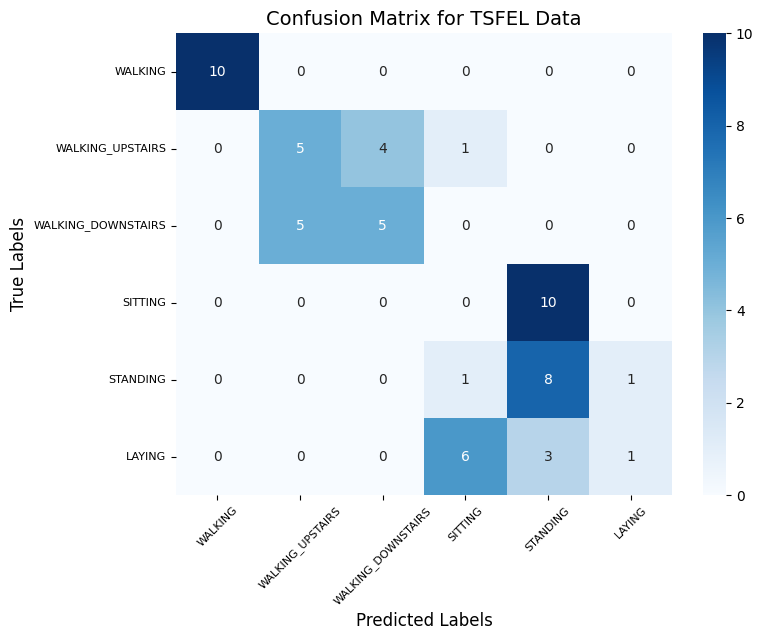

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for TSFEL Data', fontsize=14)

plt.show()
